# Credit Card Anomaly/Fraud Detection

**Final Project for Unsupervised Algorithms in Machine Learning**

**Data Download**: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/download?datasetVersionNumber=3

### Table of Contents

- [1 Introduction](#introduction)
  - [1.1 Subject Background](#subject-background)
  - [1.2 Dataset](#dataset)
  - [1.3 Model Evaluation](#model-evaluation)
  - [1.4 Library Import](#library-import)
- [2 EDA/Data Preparation](#data-preparation)
  - [2.1 Data Import](#data-import)
  - [2.2 Data Exploration](#data-exploration)
  - [2.3 Feature Selection Using Z-test](#feature-selection-using-z-test)
- [3 Modeling](#modeling)
  - [3.1 Introduction to Models](#introduction-to-models)
  - [3.2 Isolation Forest](#isolation-forest)
  - [3.3 Local Outlier Factor](#local-outlier-factor)
  - [3.4 Multi-variate Gaussian Distribution](#multi-variate-gaussian-distribution)


## 1 Introduction <a name="introduction"></a>

### 1.1 Subject Background  <a name="subject-background"></a>

Fraudulent activities related to credit cards have grown in complexity, thanks to the utilization of advanced technologies by criminals. Identifying anomalous transactions has become a challenging task, especially without prior reports from customers. Consequently, the incorporation of machine learning algorithms becomes essential when handling financial or sensitive customer data. These algorithms possess the capability to analyze large volumes of diverse data types, such as texts, images, and videos. By discerning patterns swiftly and accurately, they play a crucial role in detecting anomalies within seconds. Anomaly detection involves recognizing data points, items, observations, or events that deviate from the anticipated pattern within a specified group. While these anomalies are rare occurrences, they can signify substantial and noteworthy threats, such as cyber intrusions or fraud. The application of anomaly detection is prevalent in behavioral analysis and various analytical methodologies, facilitating the learning process related to detecting, identifying, and predicting the occurrence of these irregularities.

### 1.2 Dataset <a name="dataset"></a>

In the dataset, there are transactions executed using credit cards in the September of 2013, specifically by cardholders in Europe. Over a period of two days, there were only 492 instances of fraud out of a total of 284,807 transactions, resulting in a dataset that is markedly imbalanced. The positive class, which signifies fraudulent activities, represents a mere 0.172% of the entire transaction volume.  This will make it difficult 

The dataset exclusively consists of numerical input variables derived from a PCA transformation. Unfortunately, owing to confidentiality constraints, the original features and additional background information regarding the data remain undisclosed. Principal components V1 through V28 are the products of the PCA, while 'Time' and 'Amount' remain unaltered by this transformation. 'Time' signifies the seconds elapsed between each transaction and the initial transaction in the dataset, while 'Amount' denotes the transaction amount—a feature that finds utility, for instance, in example-dependent cost-sensitive learning. The 'Class' feature serves as the response variable, taking on a value of 1 in cases of fraud and 0 otherwise.

### 1.3 Model Evaluation <a name="model-evaluation"></a>

Due to the highly skewed nature of the data, with only 0.17% of transactions being fraudulent out of 280,000 samples, relying on accuracy is not a reliable metric. A model predicting all transactions as normal would achieve a misleadingly high accuracy of 99.83%.

In addressing this imbalance, it's essential to focus on metrics such as Recall, Precision, and their harmonic mean, the F1 score. I've made efforts to optimize each model's hyperparameters to achieve the best F1 score.

It's crucial to note that the models presented here do not consider the temporal sequences, despite having time as a distinct feature. To effectively handle the time series nature of anomaly detection, methods like RNN or LSTM may be more appropriate—though exploration of these approaches may be covered in a separate notebook.

It's worth mentioning that the training set deliberately excludes any instances of fraud. Consequently, when the model encounters fraudulent transactions in the test set, they stand out from the normal transactions. I've experimented with dividing the fraud instances, allocating half to a validation subset and half to the test set, observing a decrease in the F1 score.

### 1.4 Library Import <a name="library-import"></a>


In [1]:
import pandas as pd
import numpy as np
from numpy import ma
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import matplotlib
import matplotlib.colors as colors
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support,accuracy_score
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings("ignore")

## 2 Data Preparation <a name="library-import"></a>

### 2.1 Data Import <a name="data-import"></a>

In [2]:
dfRaw = pd.read_csv("data/creditcard.csv")
df = dfRaw.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2.2 Data Exploration <a name="data-exploration"></a>

In exploring the data, we will see that the data is very clean to begin with.  There are no nulls or missing values in any columns.  There is also plenty of data to explore.  We wil see as we examine the data further that there is significant overlap in the features between fraud and normal transactions. This is one element that makes it so difficult to identify fraud transactions.  We will also see the two separate sections of transactions.  This is reflective of the two-day window of time over which the transactions occured.

In [3]:
df[df.columns].isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

data:  (284807, 31)
normal_data:  (284315, 31)
fraud_data:  (492, 31)
Percent fraud:  0.17305 %
____________________________________________________________________________________________________


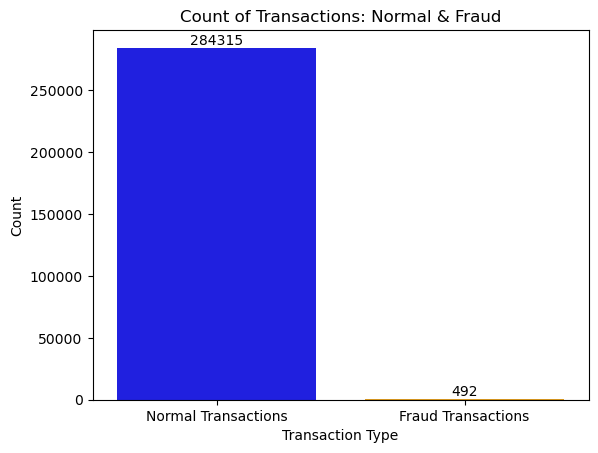

In [4]:
data = df.copy()
normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data: ", data.shape)
print("normal_data: ", normal_data.shape)
print("fraud_data: ", fraud_data.shape)
print("Percent fraud: ", round(100 * fraud_data.shape[0] / normal_data.shape[0], 5), "%")
print("_" * 100)

values = [normal_data.shape[0], fraud_data.shape[0]]
colors = ['blue', 'orange']

ax = sns.barplot(x=['Normal Transactions', 'Fraud Transactions'], y=values, palette=colors)

plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Count of Transactions: Normal & Fraud')

for i, v in enumerate(values):
    ax.text(i, v + 50, str(v), ha='center', va='bottom')

plt.show()

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

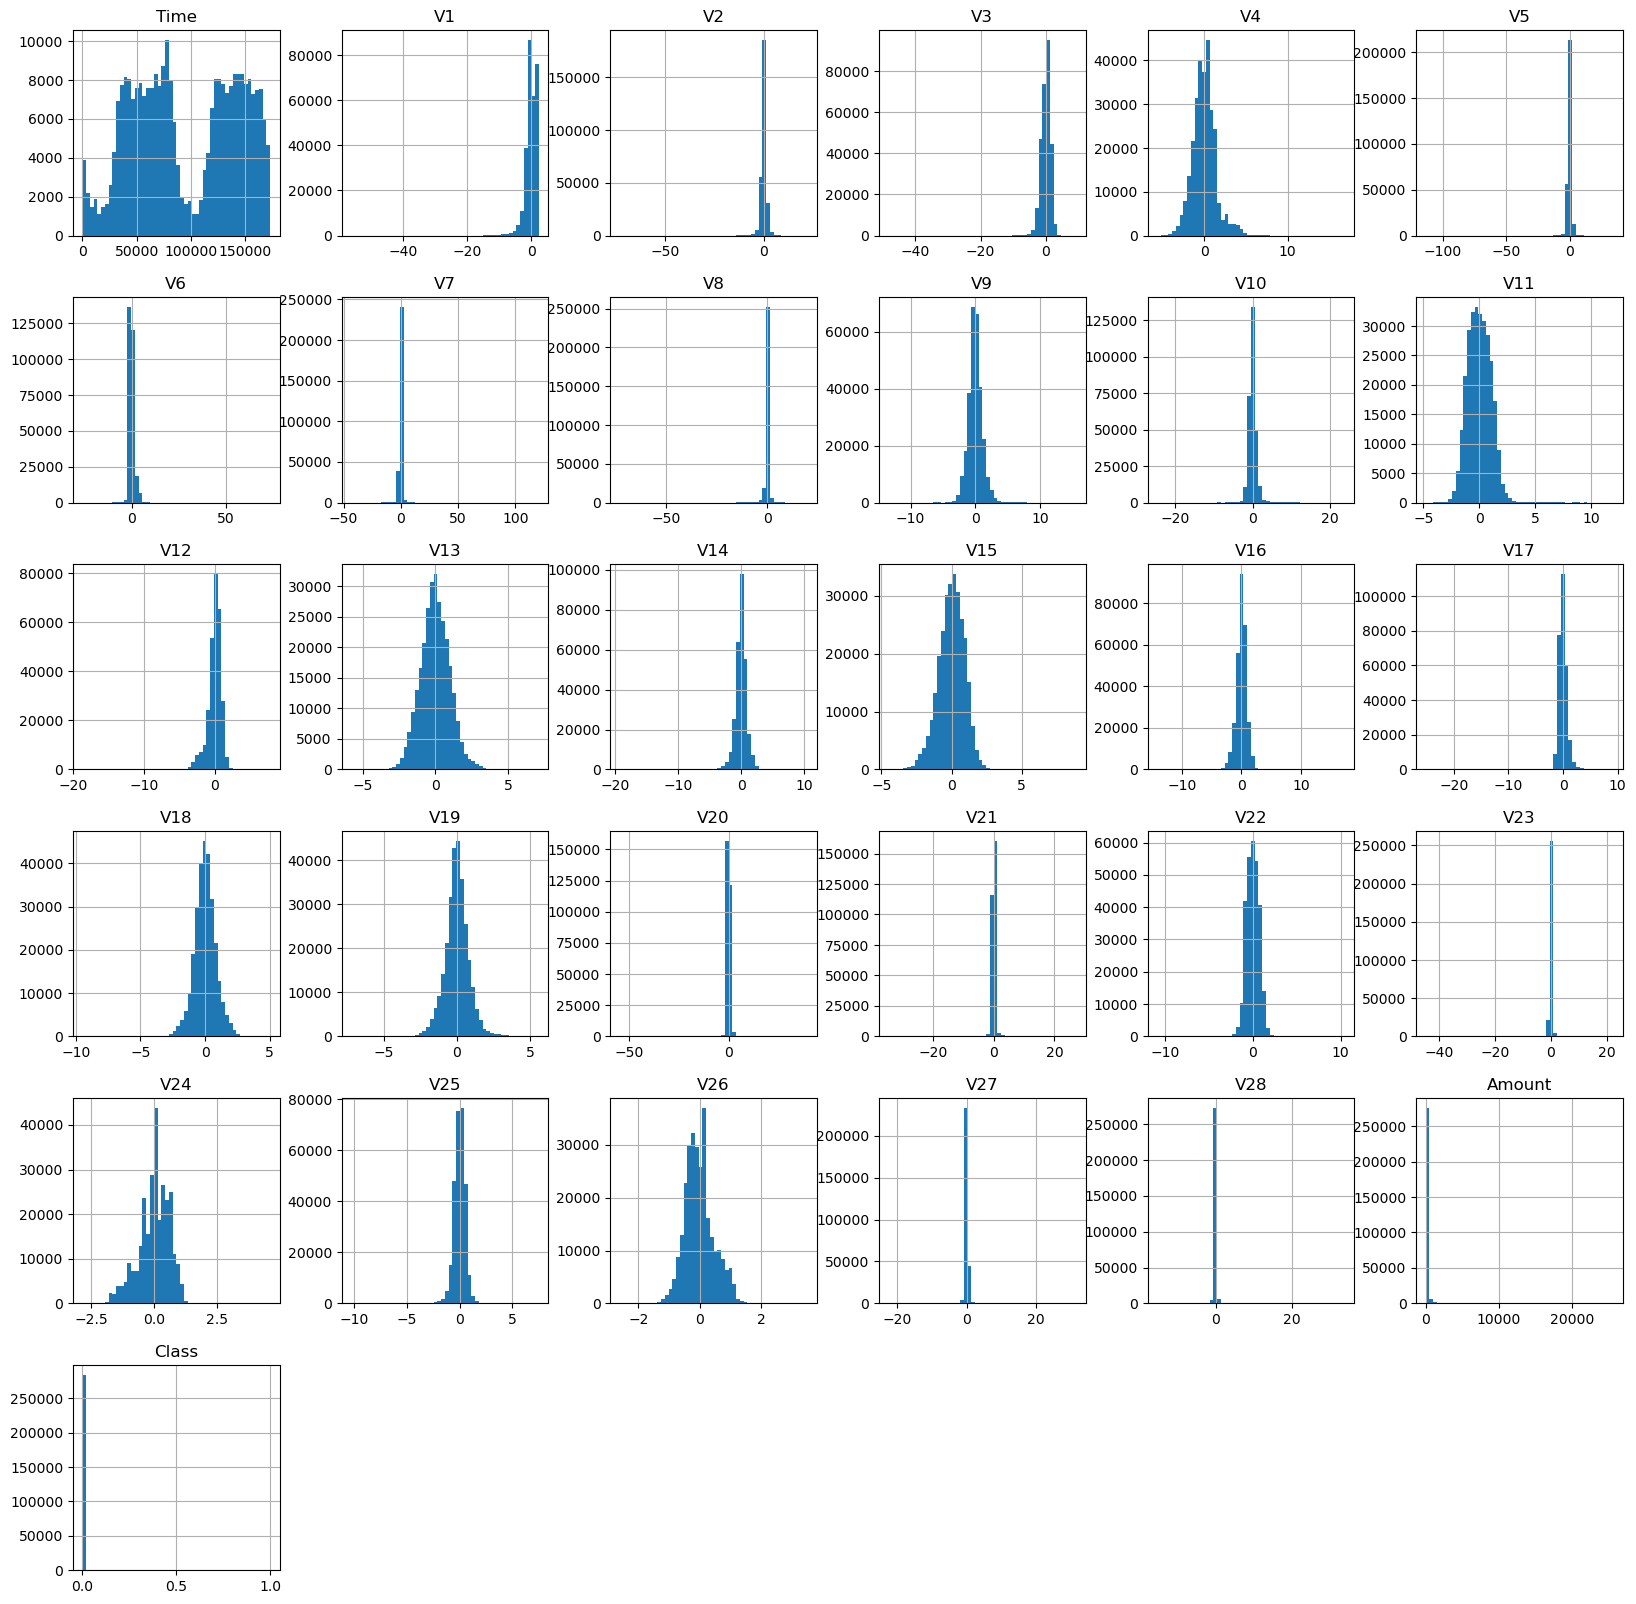

In [6]:
df.hist(bins = 50, figsize = (20,20))
plt.show()

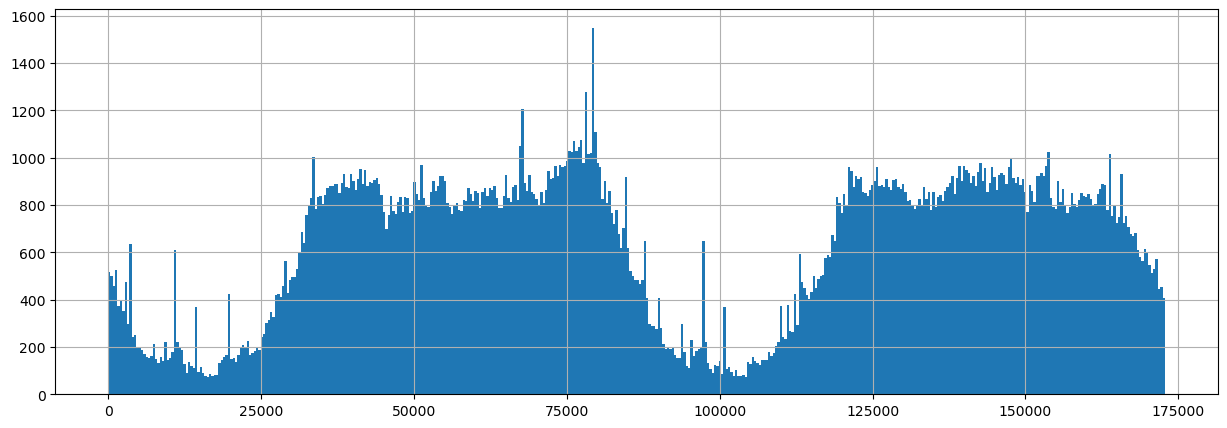

In [7]:
df['Time'].hist(bins = 450, figsize = (15,5))
plt.show()

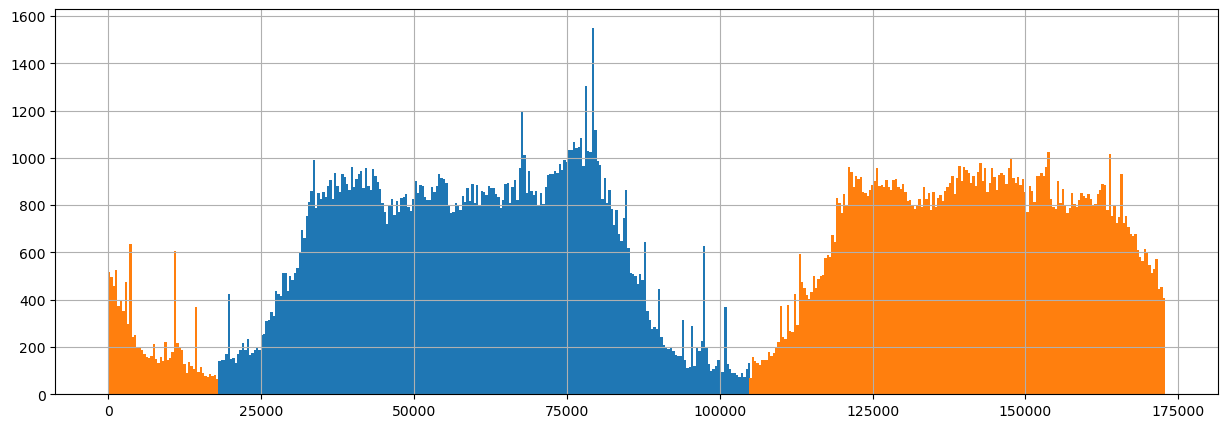

In [8]:
Data = df.loc[(df['Time']>18001) & (df['Time']<105000),:]
Data_test = df.loc[(df['Time']<18000) | (df['Time']>105001),:] 

Data['Time'].hist(bins = 225, figsize = (15,5))
Data_test['Time'].hist(bins = 450, figsize = (15,5))
plt.show()

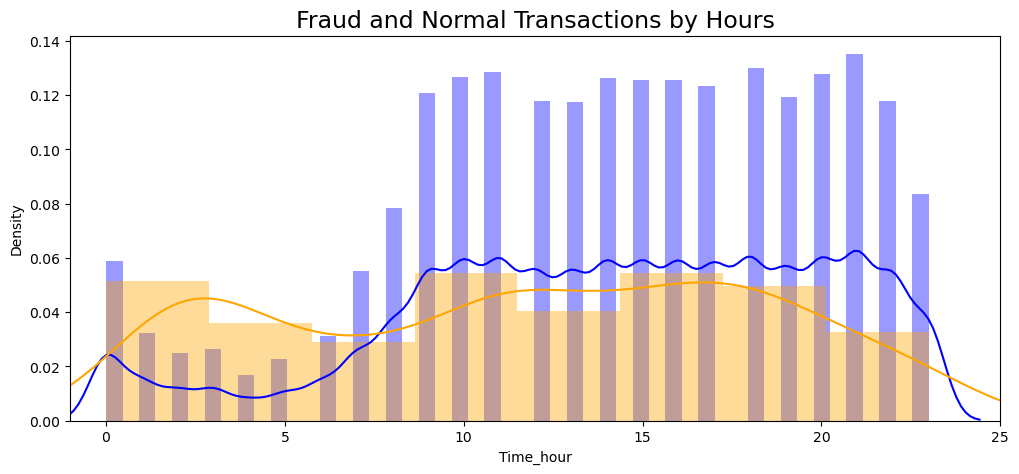

In [9]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='blue')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='orange')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

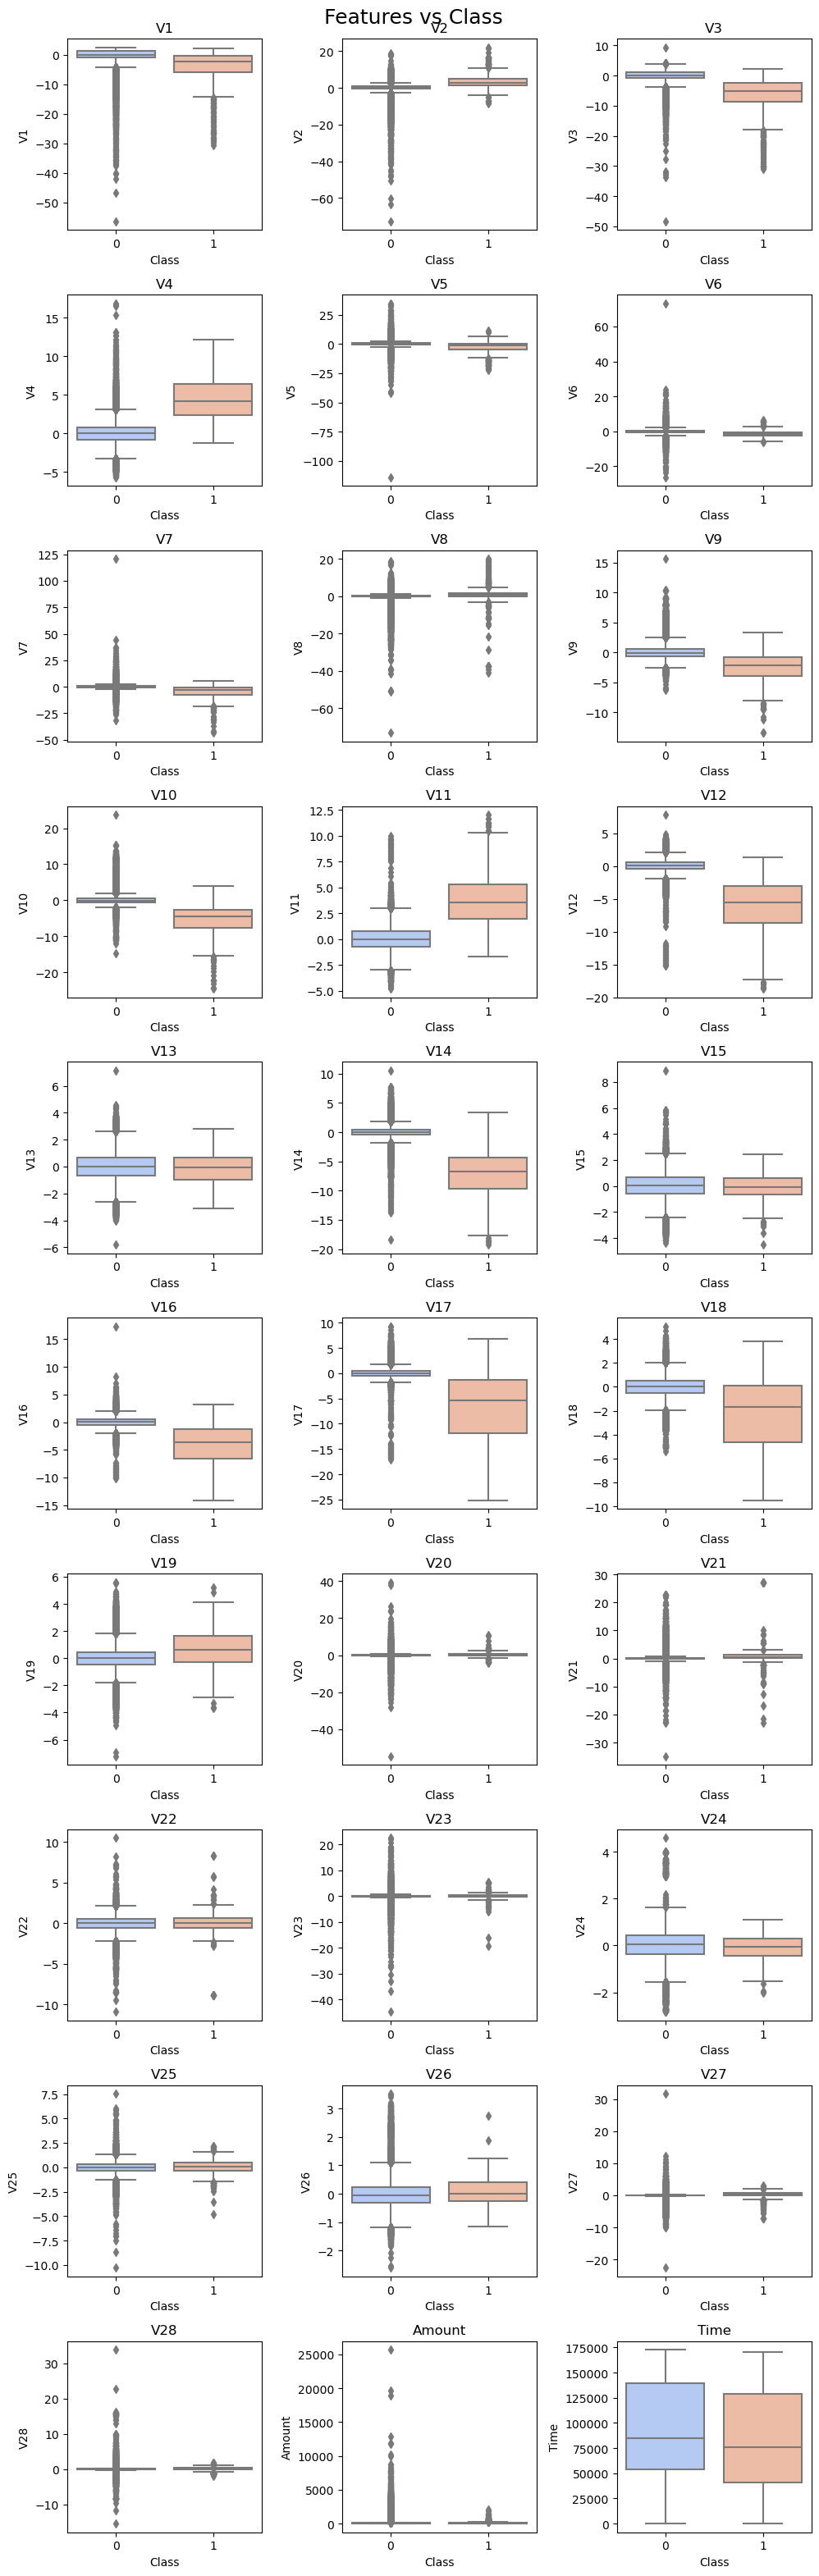

In [10]:
fig, axes = plt.subplots(nrows=10, ncols=3,figsize=(10,32))
fig.suptitle('Features vs Class\n', size = 18)

count = 1

for i in range(10):
    for j in range(3):
        if count <= 28:
            sns.boxplot(ax=axes[i, j], data=df, x='Class', y=f"V{count}", palette='coolwarm')
            axes[i,j].set_title(f"V{count}");
        elif count == 29:
            sns.boxplot(ax=axes[i, j], data=df, x='Class', y=f"Amount", palette='coolwarm')
            axes[i,j].set_title(f"Amount");
        else:
            sns.boxplot(ax=axes[i, j], data=df, x='Class', y=f"Time", palette='coolwarm')
            axes[i,j].set_title(f"Time");
        
        count += 1
        
plt.tight_layout()

In [11]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

dfCopy = df.copy()

dfCopy.drop(['Time','Time_hour', 'Amount'], axis=1, inplace=True)


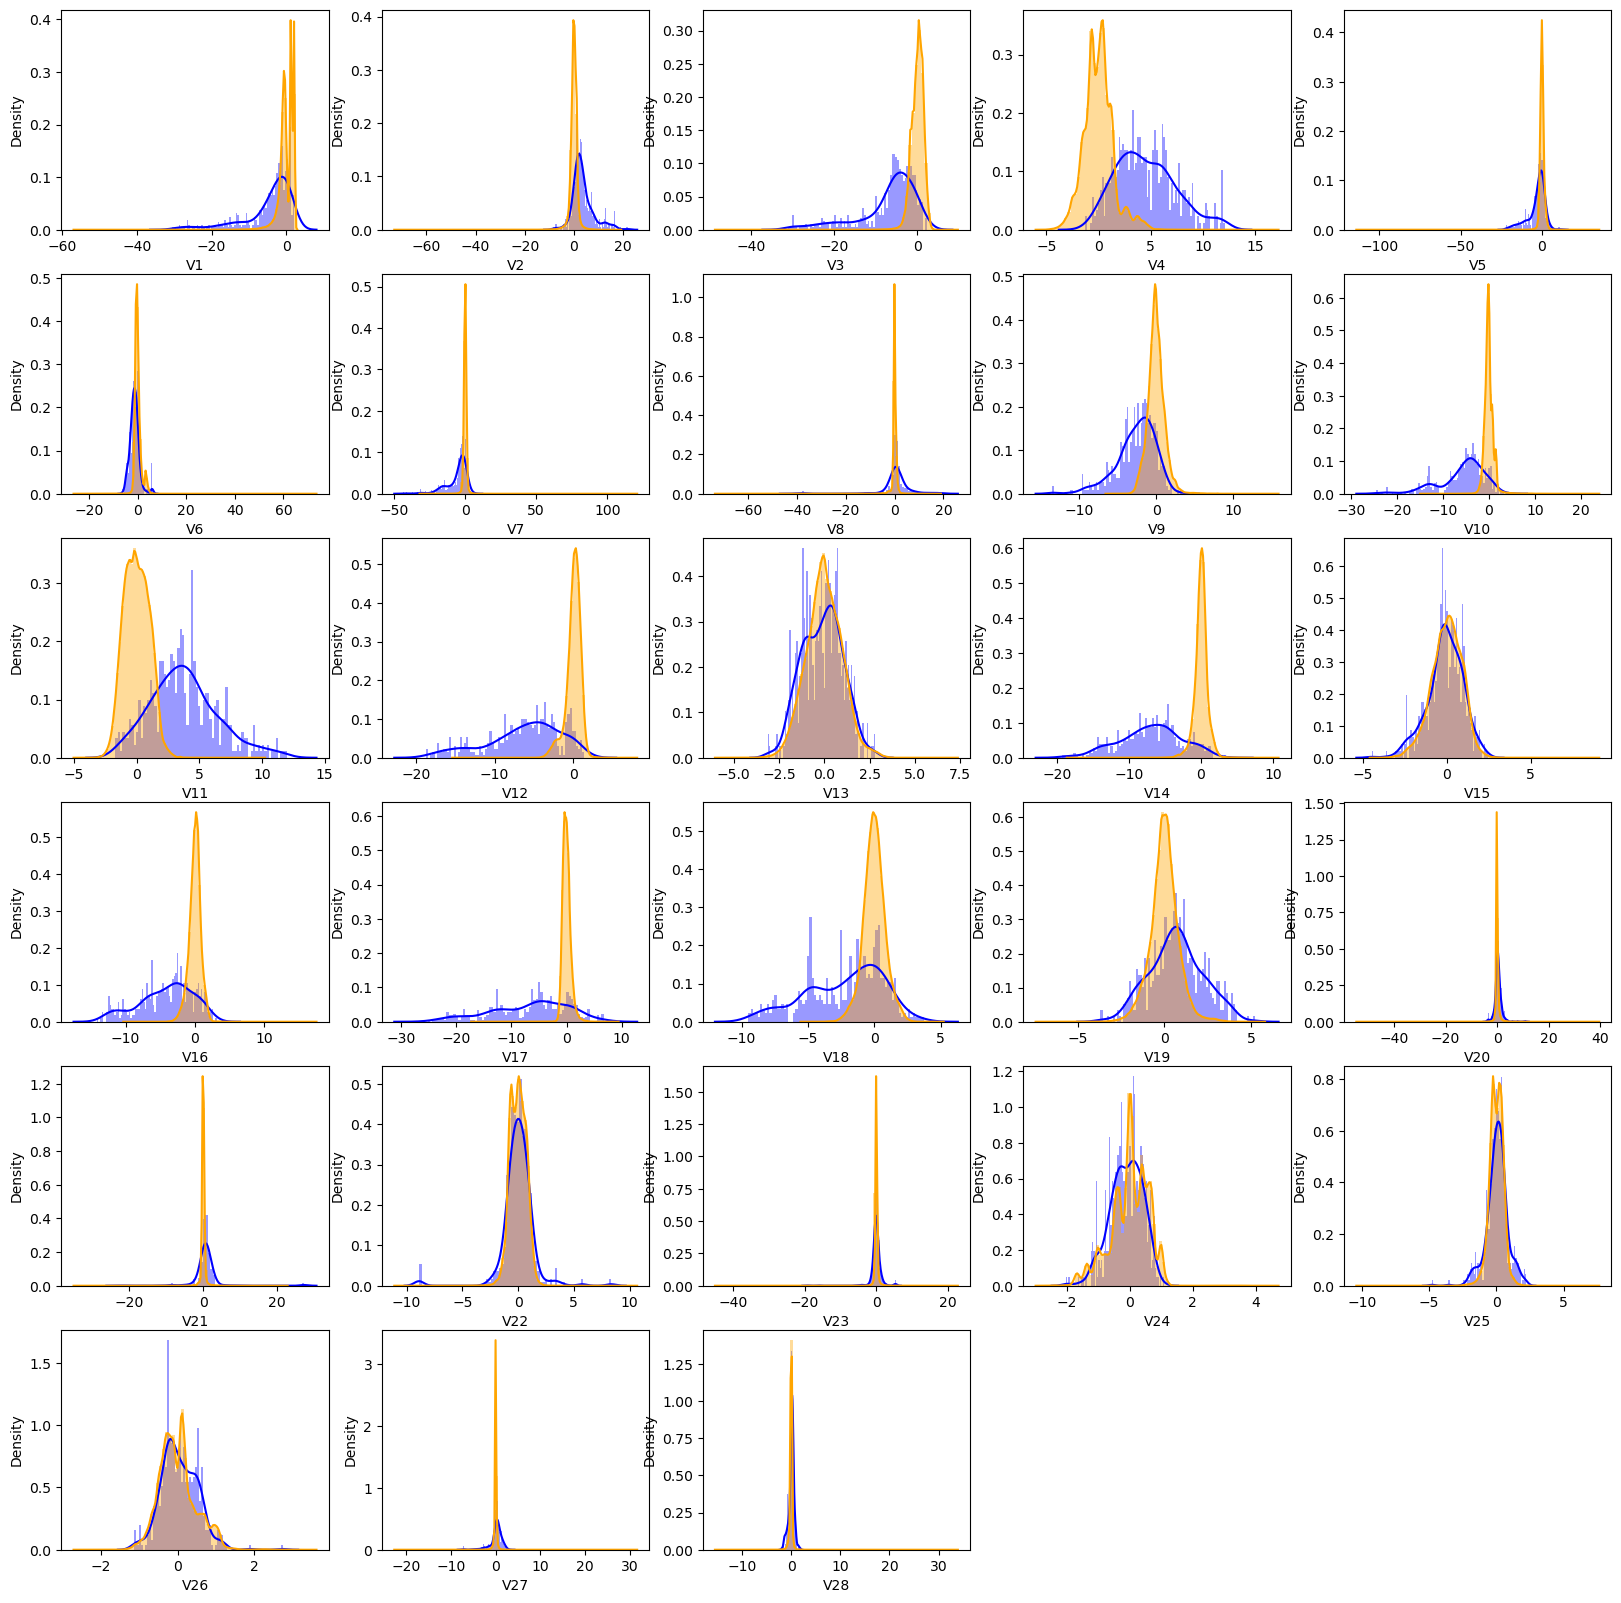

In [12]:
columns = dfCopy.drop('Class', axis=1).columns
grid = gridspec.GridSpec(6, 5)

plt.figure(figsize=(20, 10*2))

for n, col in enumerate(dfCopy[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(dfCopy[dfCopy.Class == 1][col], bins=75, color='blue')
    sns.distplot(dfCopy[dfCopy.Class == 0][col], bins=75, color='orange') 
    ax.set_ylabel('Density')

plt.show()

Upon examination, it becomes apparent that the data distribution of certain features (such as V18, V20, V25) for normal and fraud cases shows overlap, rendering them indistinguishable. These specific features may lack the ability to effectively discriminate between normal and fraudulent transactions.

## Feature Selection Using Z-test

To address this issue, we will perform hypothesis testing to identify features that exhibit statistical significance. The chosen method is a Z-test, with valid transactions serving as our population.

The primary goal is to ascertain whether the values of fraud transactions significantly differ from those of normal transactions across all features. The significance level for this two-tailed test is established at 0.01.

### Scenario:

- Population: Valid transactions
- Sample: Fraud transactions
- Test Type: Two-tailed Z-test
- Level of Significance: 0.01
- Corresponding Critical Value: 2.58

### Hypothesis:

- H0: There is no difference (insignificant)
- H1: There is a difference (significant)


In [13]:
normal = dfCopy.loc[dfCopy['Class'] == 0, :]
normal.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,0.009824,...,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,0.0
std,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,1.044204,...,0.769404,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,0.0
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,-14.741096,...,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.0
25%,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,-0.532880,...,-0.211764,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,0.0
50%,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,-0.091872,...,-0.062646,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,0.0
75%,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,0.455135,...,0.132401,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,0.0
max,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,23.745136,...,39.420904,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,0.0


In [14]:
fraud = dfCopy.loc[dfCopy['Class'] == 1, :]
fraud.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,1.0
std,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,4.897341,...,1.346635,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,0.0
min,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,...,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,1.0
25%,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,-7.756698,...,-0.171760,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.0
50%,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,...,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,1.0
75%,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,-2.614184,...,0.822445,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,1.0
max,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,4.031435,...,11.059004,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,1.0


In [15]:
def ztest(feature):
    
    mean = normal[feature].mean()
    std = fraud[feature].std()
    zScore = (fraud[feature].mean() - mean) / (std/np.sqrt(sample_size))
    
    return zScore

In [16]:
columns= dfCopy.drop('Class', axis=1).columns
sample_size=len(fraud)
significant_features=[]
critical_value=2.58

for i in columns:
    
    z_vavlue=ztest(i)
    
    if( abs(z_vavlue) >= critical_value):    
        print(i," is statistically significant") #Reject Null hypothesis. i.e. H0
        significant_features.append(i)
    else:
        print(i," is NOT statistically significant")
print(significant_features)

V1  is statistically significant
V2  is statistically significant
V3  is statistically significant
V4  is statistically significant
V5  is statistically significant
V6  is statistically significant
V7  is statistically significant
V8  is NOT statistically significant
V9  is statistically significant
V10  is statistically significant
V11  is statistically significant
V12  is statistically significant
V13  is NOT statistically significant
V14  is statistically significant
V15  is NOT statistically significant
V16  is statistically significant
V17  is statistically significant
V18  is statistically significant
V19  is statistically significant
V20  is statistically significant
V21  is statistically significant
V22  is NOT statistically significant
V23  is NOT statistically significant
V24  is statistically significant
V25  is NOT statistically significant
V26  is NOT statistically significant
V27  is statistically significant
V28  is statistically significant
['V1', 'V2', 'V3', 'V4', 'V5'

In [17]:
significant_features.append('Class')
df= df[significant_features]

inliers = df[df.Class==0]
ins = inliers.drop(['Class'], axis=1)

outliers = df[df.Class==1]
outs = outliers.drop(['Class'], axis=1)

ins.shape, outs.shape

((284315, 21), (492, 21))

## 3 Modeling <a name="modeling"></a>

### 3.1 Introduction to Models <a name="introduction-to-models"></a>

For the task of anomaly detection, we will employ three unsupervised learning algorithms.

1. **Isolation Forest**

   The Isolation Forest is an unsupervised anomaly detection algorithm that leverages the properties of anomalies being both "Few" and "Different" to identify their presence. Given that anomalies are scarce and exhibit distinct characteristics, they are more susceptible to isolation. This algorithm individually isolates each data point, categorizing them as outliers or inliers based on the time it takes to separate them. If an attempt is made to isolate a point that is clearly not an outlier, it will have numerous points in its vicinity, making isolation challenging. Conversely, if the point is an outlier, it will be isolated easily as it stands alone.
   
2. **Local Outlier Factor (LOF)**

   The Local Outlier Factor (LOF) algorithm is another unsupervised anomaly detection method that computes the local density deviation of a given data point in relation to its neighbors. It assesses the density around a specific point, comparing it to the density of neighboring points. In essence, LOF identifies samples as outliers if their density significantly deviates from that of their neighbors. The algorithm considers as outliers those samples exhibiting notably lower density than their neighboring points.

3. **Multi-variate Gaussian Distribution**

   The Multivariate Gaussian Distribution, extending the Gaussian model to multiple dimensions, plays a crucial role in outlier detection. By modeling the joint probability of observing a set of variables simultaneously and capturing correlations between them, this distribution enables the assessment of the probability density function (PDF) for each data point. Points with exceptionally low probabilities, indicative of significant deviations from the expected distribution, are flagged as potential outliers. Particularly effective in high-dimensional datasets, where capturing variable dependencies is vital, this method provides a comprehensive approach to anomaly detection.


In [18]:
def normal_accuracy(values):
    
    tp=list(values).count(1)
    total=values.shape[0]
    accuracy=np.round(tp/total,4)
    
    return accuracy

def fraud_accuracy(values):
    
    tn=list(values).count(-1)
    total=values.shape[0]
    accuracy=np.round(tn/total,4)
    
    return accuracy

### 3.2 Isolation Forest <a name="isolation-forest"></a>

In [19]:
ISF = IsolationForest()
ISF.fit(ins)

normal_isf = ISF.predict(ins)
fraud_isf = ISF.predict(outs)

TN_isf = list(normal_isf).count(1)
FN_isf = list(normal_isf).count(-1)
TP_isf = list(fraud_isf).count(-1)
FP_isf = list(fraud_isf).count(1)
precision_isf = TN_isf/(TN_isf+TP_isf)
recall_isf = TN_isf/(TN_isf+FN_isf)

in_accuracy_isf=normal_accuracy(normal_isf)
out_accuracy_isf=fraud_accuracy(fraud_isf)

print("Accuracy in Detecting Normal Cases:", in_accuracy_isf)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_isf, "\n")

print("Precision = ", precision_isf)
print("Recall = ", recall_isf)
print("F1 Score = ", 2*(precision_isf*recall_isf)/(precision_isf+recall_isf))


Accuracy in Detecting Normal Cases: 0.9484
Accuracy in Detecting Fraud Cases: 0.8638 

Precision =  0.9984262523328494
Recall =  0.9483530591069764
F1 Score =  0.9727456883567142


### 3.3 Local Outlier Factor <a name="local-outlier-factor"></a>

In [20]:
LOF = LocalOutlierFactor(novelty=True)
LOF.fit(ins)

normal_lof = LOF.predict(ins)
fraud_lof = LOF.predict(outs)

TN_lof = list(normal_lof).count(1)
FN_lof = list(normal_lof).count(-1)
TP_lof = list(fraud_lof).count(-1)
FP_lof = list(fraud_lof).count(1)
precision_lof = TN_lof/(TN_lof+TP_lof)
recall_lof = TN_lof/(TN_lof+FN_lof)

in_accuracy_lof=normal_accuracy(normal_lof)
out_accuracy_lof=fraud_accuracy(fraud_lof)

print("Accuracy in Detecting Normal Cases:", in_accuracy_lof)
print("Accuracy in Detecting Fraud Cases:", out_accuracy_lof)

print("Precision = ", precision_lof)
print("Recall = ", recall_lof)
print("F1 Score = ", 2*(precision_isf*recall_isf)/(precision_isf+recall_lof))

Accuracy in Detecting Normal Cases: 0.945
Accuracy in Detecting Fraud Cases: 0.2033
Precision =  0.9996279637339048
Recall =  0.9450468670312857
F1 Score =  0.9744005011012092


### 3.4 Multi-variate Gaussian Distribution <a name="multi-variate-gaussian-distribution"></a>

In [21]:
data = dfRaw.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(492)])

In [22]:
p = multivariate_normal(mean=np.mean(X_train,axis=0), cov=np.cov(X_train.T))

In [23]:
x = p.pdf(X_test)

EpsF1 = []

epsilons = [1e-10, 1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80, 1e-90, 1e-100, 1e-110, 1e-120,
           1e-130, 1e-140, 1e-150, 1e-160, 1e-170, 1e-180, 1e-190, 1e-200, 1e-210, 1e-220, 1e-230, 1e-240]

for e in range(len(epsilons)):
    eps = epsilons[e]
    pred = (x <= eps)
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([eps, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['epsilon', 'F1'])
EpsF1df.head()

,epsilon,F1
0,1.000000e-10,0.0130
1,1.000000e-20,0.1143
2,1.000000e-30,0.2772
3,1.000000e-40,0.3767
4,1.000000e-50,0.4399


In [24]:
EpsF1df.loc[EpsF1df['F1'].idxmax()]

epsilon    1.000000e-140
F1          7.139000e-01
Name: 13, dtype: float64

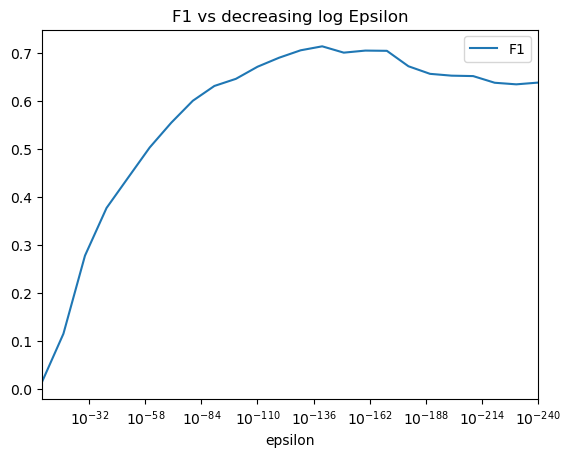

In [25]:
EpsF1df.plot.line("epsilon","F1")
plt.xscale('log')
plt.xlim(1e-10, 1e-240)
plt.title("F1 vs decreasing log Epsilon")
plt.show()

In [26]:
eps = EpsF1df.loc[EpsF1df['F1'].idxmax()]['epsilon']

print("epsilon ", eps)
print("_"*50)
pred = (x<=eps)

epsilon  1e-140
__________________________________________________


In [27]:
precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test,pred, average='binary')
print("precision ", precision)
print("recall ", recall)
print("F1 score on Test", fbeta_score)
print("Accuracy on Normal Transactions = 0.9984120417939925")
print("Accuracy on Fraud Transactions = 0.674502712477396")

precision  0.674502712477396
recall  0.758130081300813
F1 score on Test 0.7138755980861244
Accuracy on Normal Transactions = 0.9984120417939925
Accuracy on Fraud Transactions = 0.674502712477396


## 4 Conclusion <a name="conclusion"></a>

To summarize these three different models efficacy as demonstrated by their F1 Score:

- **Isolation Forest:  0.9754617010749788**
- **Local Outlier Factor:  0.9797019997387962**
- **Multi-variate Gaussian Distribution:  0.7138755980861244**

The Local Outlier Factor is the best model shown by the F1 Score. The Local Outlier Factor (**LOF**) might be better than the Isolation Forest (**IF**) and the Multi-variate Gaussian Distribution (**MVG**) for the following reasons:

#### Sensitivity to Data Density

- **LOF**: LOF is particularly effective when dealing with datasets where anomalies have different densities than normal instances. It does not assume that the data follows a specific distribution and is capable of identifying local density variations.
  
- **IF**: IF might struggle if anomalies are not well isolated, as it relies on the fact that anomalies are few and different, which might not be the case if they are densely distributed among normal instances.
  
- **MVG**: MVG assumes that the data follows a multi-variate Gaussian distribution, which might not be suitable for datasets with complex or non-Gaussian structures.

#### Handling Non-linear Relationships

- **LOF**: LOF is more capable of capturing non-linear relationships in the data. It does not make assumptions about the shape of the clusters or decision boundaries, making it suitable for datasets with intricate patterns.
  
- **IF**: IF is effective when anomalies can be isolated using linear splits. However, for datasets with complex non-linear relationships, IF may struggle to create effective partitions.
  
- **MVG**: MVG assumes a linear relationship between features, and it may not perform well on datasets with non-linear anomalies.

#### Robustness to Dimensionality

- **LOF**: LOF is generally more robust to high-dimensional datasets as it focuses on local relationships between points, and it is less affected by the curse of dimensionality.
  
- **IF**: IF can face challenges in high-dimensional spaces due to the increased complexity of isolating instances effectively.
  
- **MVG**: MVG might struggle in high dimensions if the data does not conform well to a Gaussian distribution.

#### Interpretability

- **LOF**: LOF provides scores that indicate the degree of anomaly for each data point, making it more interpretable in terms of understanding the level of abnormality.
  
- **IF**: IF provides anomaly scores, but the interpretability might be lower compared to LOF.
  
- **MVG**: MVG provides probability density estimates, and interpreting anomalies might require setting a threshold on the density.

In summary, LOF is often favored in scenarios where the data has varying densities, non-linear relationships, and high dimensionality. The dataset of transactions has all of these characteristics, which is why the Local Outlier Factor might have been a better model for this particular situation.